In [40]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from random import randint

plt.rcParams["figure.figsize"] = (20, 16)
warnings.simplefilter("ignore")
os.listdir()

['.ipynb_checkpoints',
 'analyse.ipynb',
 'output.csv',
 'whats.csv',
 'youtube20221108_165214_raw.csv',
 'youtube20221108_182416.csv',
 'youtube20221108_182416_raw.csv',
 'yt.csv',
 'yt_whats.csv']

In [2]:
current_file = "yt.csv"
data = pd.read_csv(current_file)
#data = pd.read_csv('output.csv')

data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id
0,1665756440928,65535,5525,2.0,0.0,0.0,1,2,-2,144,-2,4,3
1,1665756441003,65535,5600,2.0,0.0,0.0,1,6,-2,256,-2,6,3
2,1665756441008,65535,5605,2.0,0.0,0.0,1,2,-2,144,-2,4,3
3,1665756441013,65535,5610,2.0,0.0,0.0,1,6,-2,256,-2,6,3
4,1665756441023,65535,5620,2.0,0.0,0.0,1,6,-2,256,-2,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140,1665756564233,65535,5950,2.0,0.0,0.0,1,6,-2,256,-2,6,3
12141,1665756564248,65535,5965,2.0,0.0,0.0,1,2,-2,144,-2,4,3
12142,1665756564268,65535,5985,2.0,0.0,0.0,1,2,-2,144,-2,4,3
12143,1665756564288,65535,6005,2.0,0.0,0.0,1,2,-2,144,-2,4,3


In [3]:
data.describe()

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id
count,1.214500e+04,12145.000000,12145.000000,12145.000000,12145.000000,12145.000000,12145.0,12145.000000,12145.0,12145.000000,12145.0,12145.000000,12145.000000
mean,1.665756e+12,48058.430959,5017.840510,1.889667,5.003376,1.561301,1.0,9.269164,-2.0,6272.906381,-2.0,12.290490,3.402882
std,3.590161e+04,28956.387404,3053.630527,0.456630,10.703841,2.594978,0.0,10.454081,0.0,13002.354021,0.0,16.519729,0.770723
min,1.665756e+12,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,-2.0,32.000000,-2.0,1.000000,1.000000
25%,1.665756e+12,87.000000,2441.000000,2.000000,0.000000,0.000000,1.0,2.000000,-2.0,144.000000,-2.0,4.000000,3.000000
50%,1.665756e+12,65535.000000,4685.000000,2.000000,0.000000,0.000000,1.0,6.000000,-2.0,256.000000,-2.0,4.000000,3.000000
75%,1.665757e+12,65535.000000,7805.000000,2.000000,9.000000,5.000000,1.0,9.000000,-2.0,712.000000,-2.0,6.000000,4.000000
max,1.665757e+12,65535.000000,10239.000000,2.000000,39.000000,6.000000,1.0,31.000000,-2.0,36696.000000,-2.0,50.000000,6.000000


In [4]:


def first_preprocess(data) :
    data.sort_values(by="Time", ascending=True,inplace =True)
    data.reset_index(drop=True, inplace = True)
    data["Time"] = pd.to_datetime(data.Time, unit='ms')
    reserved_values = [5, 65534, 65535]
    data=data[~data.rnti.isin(reserved_values)] # on enlève les plages reservées
    return data

data = first_preprocess(data)
data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id
473,2022-10-14 14:07:27.262,85,1619,2.0,9.0,6.0,1,2,-2,296,-2,7,4
477,2022-10-14 14:07:27.287,85,1644,0.0,9.0,6.0,1,18,-2,336,-2,1,4
479,2022-10-14 14:07:27.303,85,1660,0.0,9.0,6.0,1,31,-2,336,-2,1,4
481,2022-10-14 14:07:27.311,85,1668,2.0,9.0,6.0,1,2,-2,72,-2,2,4
482,2022-10-14 14:07:27.313,85,1670,2.0,9.0,6.0,1,2,-2,72,-2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,2022-10-14 14:09:13.587,87,5544,0.0,31.0,5.0,1,24,-2,1064,-2,2,6
11338,2022-10-14 14:09:13.611,87,5568,2.0,31.0,5.0,1,28,-2,712,-2,1,6
11457,2022-10-14 14:09:15.172,87,7129,2.0,31.0,5.0,1,28,-2,1480,-2,2,6
11458,2022-10-14 14:09:15.187,87,7144,0.0,31.0,5.0,1,9,-2,936,-2,6,6


In [5]:
data[["rnti","connection_id"]].value_counts()


rnti  connection_id
85    4                2059
86    5                 703
87    6                 478
dtype: int64

In [6]:
# pour yt et whats connec ID 4 

<AxesSubplot:>

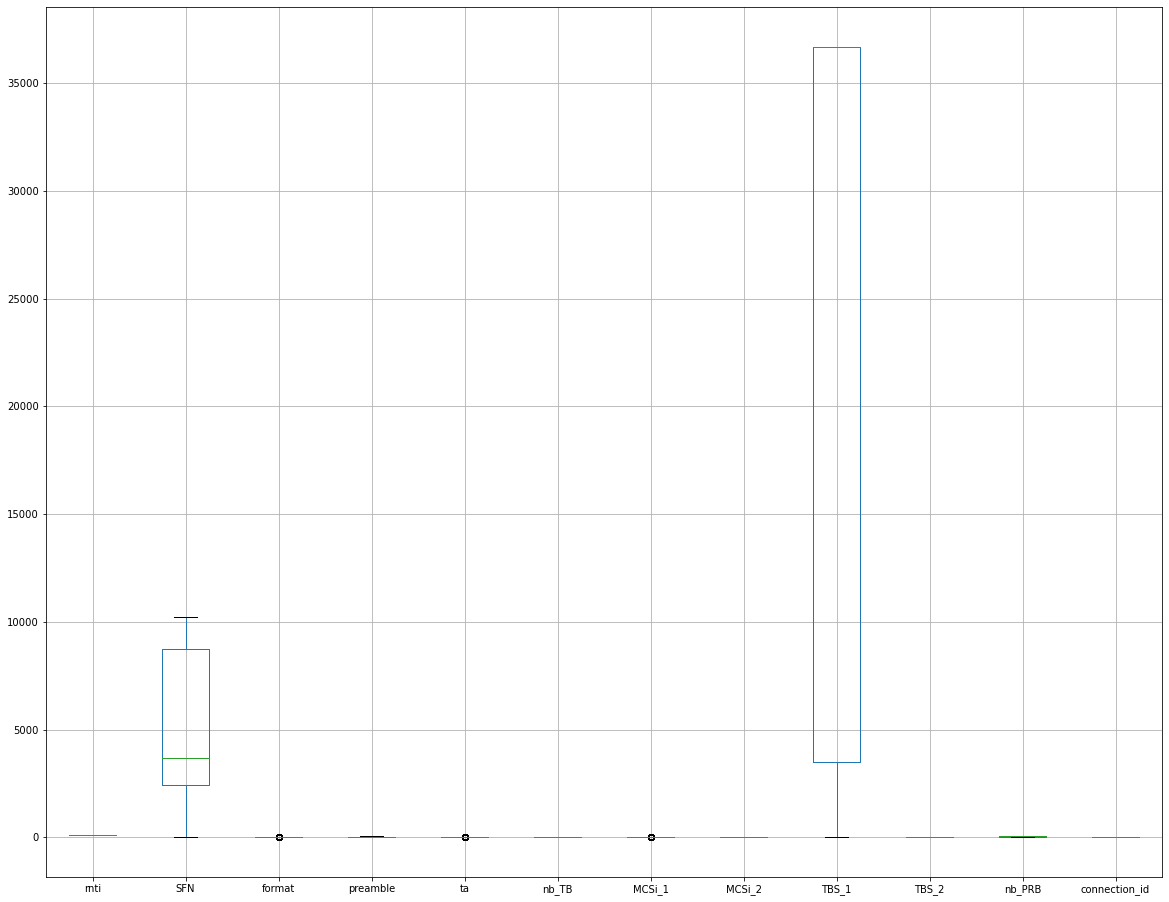

In [7]:
data.boxplot()

In [8]:
def plot_data(data,x="Time", y="cum_TBS", title = None):
    data.plot(x=x, y=y)
    if not title is None :
        plt.title(title)

# Tracé des différents connec_id

In [9]:
to_concat, col_TBS, col_TBS_sum = [], [], []
for value in data.connection_id.unique():
    tmp = data[data.connection_id==value]
    tmp[f"cum_TBS_conn_{value}"] = tmp["TBS_1"].cumsum()
    tmp[f"TBS_1_conn_{value}"] = tmp["TBS_1"]
    col_TBS.append(f"TBS_1_conn_{value}")
    col_TBS_sum.append(f"cum_TBS_conn_{value}")
    to_concat.append(tmp)
extended = pd.concat(to_concat)
extended

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id,cum_TBS_conn_4,TBS_1_conn_4,cum_TBS_conn_5,TBS_1_conn_5,cum_TBS_conn_6,TBS_1_conn_6
473,2022-10-14 14:07:27.262,85,1619,2.0,9.0,6.0,1,2,-2,296,-2,7,4,296.0,296.0,NaN,NaN,NaN,NaN
477,2022-10-14 14:07:27.287,85,1644,0.0,9.0,6.0,1,18,-2,336,-2,1,4,632.0,336.0,NaN,NaN,NaN,NaN
479,2022-10-14 14:07:27.303,85,1660,0.0,9.0,6.0,1,31,-2,336,-2,1,4,968.0,336.0,NaN,NaN,NaN,NaN
481,2022-10-14 14:07:27.311,85,1668,2.0,9.0,6.0,1,2,-2,72,-2,2,4,1040.0,72.0,NaN,NaN,NaN,NaN
482,2022-10-14 14:07:27.313,85,1670,2.0,9.0,6.0,1,2,-2,72,-2,2,4,1112.0,72.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,2022-10-14 14:09:13.587,87,5544,0.0,31.0,5.0,1,24,-2,1064,-2,2,6,NaN,NaN,NaN,NaN,13439688.0,1064.0
11338,2022-10-14 14:09:13.611,87,5568,2.0,31.0,5.0,1,28,-2,712,-2,1,6,NaN,NaN,NaN,NaN,13440400.0,712.0
11457,2022-10-14 14:09:15.172,87,7129,2.0,31.0,5.0,1,28,-2,1480,-2,2,6,NaN,NaN,NaN,NaN,13441880.0,1480.0
11458,2022-10-14 14:09:15.187,87,7144,0.0,31.0,5.0,1,9,-2,936,-2,6,6,NaN,NaN,NaN,NaN,13442816.0,936.0


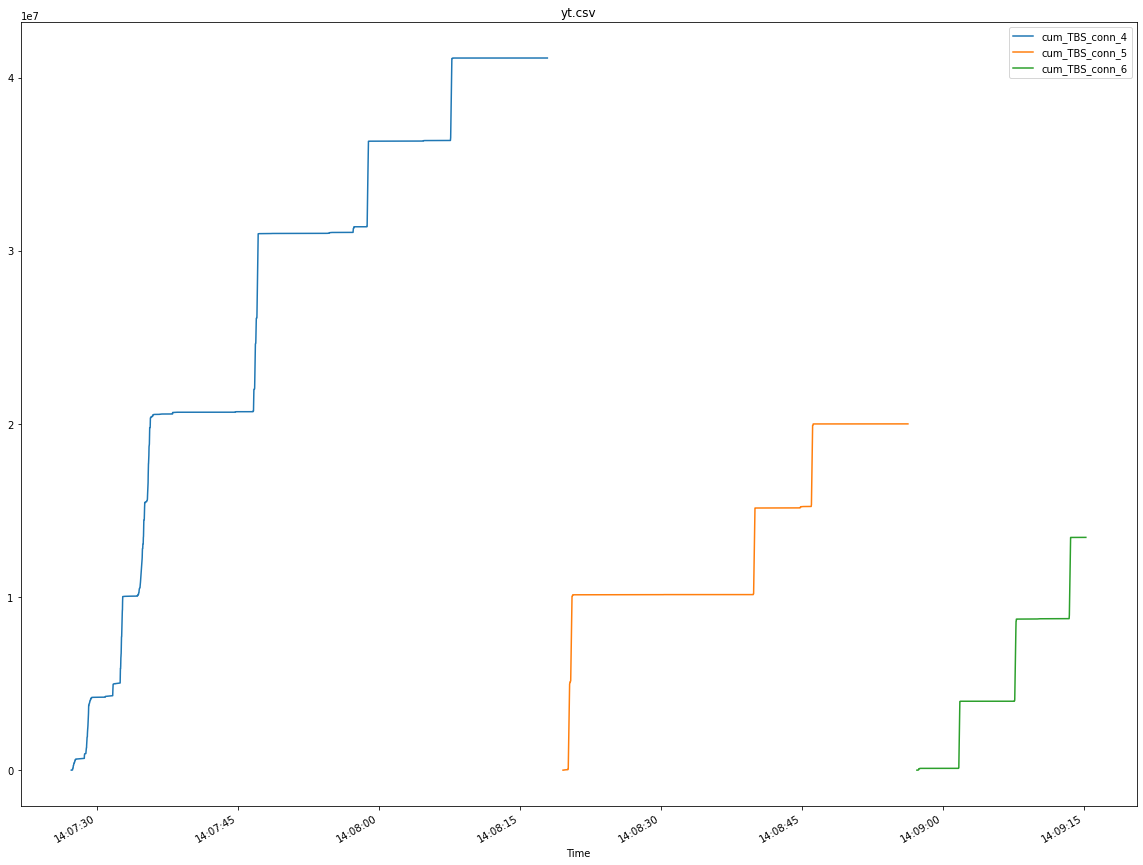

In [10]:
plot_data(extended, y=col_TBS_sum, title = current_file)

# First models

In [11]:
# 'whats.csv', 'yt.csv', 'yt_whats.csv'*


data1 = pd.read_csv('yt_whats.csv')
data2 = pd.read_csv('yt.csv')
data3 = pd.read_csv('whats.csv')


time_series = []
time_series.append((data1[data1.connection_id == 4].TBS_1,"yt"))
time_series.append((data1[data1.connection_id == 5].TBS_1,"noise"))
time_series.append((data1[data1.connection_id == 6].TBS_1,"whats"))

time_series.append((data2[data2.connection_id == 4].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 5].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 6].TBS_1,"yt"))
                   
time_series.append((data3[data3.connection_id == 4].TBS_1,"whats"))
time_series.append((data3[data3.connection_id == 5].TBS_1,"noise"))


time_series = [(ser[0].reset_index(drop=True),ser[1]) for ser in time_series]

time_series = [pd.DataFrame({f"{ser[1]}_{i}" : ser[0]} ) for i, ser in enumerate(time_series)]


#time_series
init_data = pd.concat(time_series, axis = 1)
init_data

,yt_0,noise_1,whats_2,yt_3,yt_4,yt_5,whats_6,noise_7
0,296.0,296.0,296.0,296.0,296.0,296.0,296,296.0
1,408.0,336.0,520.0,336.0,224.0,520.0,520,520.0
2,72.0,72.0,72.0,336.0,224.0,520.0,520,72.0
3,72.0,72.0,72.0,72.0,72.0,72.0,520,72.0
4,32.0,32.0,32.0,72.0,72.0,72.0,520,32.0
...,...,...,...,...,...,...,...,...
20039,NaN,NaN,NaN,NaN,NaN,NaN,840,NaN
20040,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN
20041,NaN,NaN,NaN,NaN,NaN,NaN,1096,NaN
20042,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN


In [33]:
# to apply for each time serie



# format data : 
# 2 colonne = 1time series ( valeurs de TBS + son cumsum ), name col = "{label}_{val or sum}_id"
# les lignes = time codes ( on commence à 0 pour toutes)

def pass_trhough_first_layer(data) :
    list_rows = []
    for i in tqdm(range(len(data.columns))) : # Pour chaque time serie
        useful_columns = data.columns[i]
        new_row = first_layer(data[useful_columns])
        
        new_row["label"] = useful_columns.split("_")[0]
        
        list_rows.append(new_row)
    data_final = pd.DataFrame.from_records(list_rows)
        
    
    # concatenate new rows  
    # return concatenation
    
    
    return data_final
    

def first_layer(data):
    metrics = {}
    cum_data = data.cumsum()
    
    
    
    
    # apply scaler
    
    # Here we apply models on cumulated sum
    models = ["reg_lin", "reg_iso", "reg_pol"]
    
    for model in models : 
        
        metrics = apply_simple_model(model, cum_data, metrics)
        
    # Here we can measure other metrics on none cumulated sum
    
    # Q1 to obtain plateau. median, mean Q3 , other percentiles(10, 90)... same usage I hope.
    # intuition = un plateau = TBS à 0 pendant un certain temps, ainsi x% du temps le TBS vaut 0 donc faible percentile à 0 
    percentiles = [0.1,0.25,0.5,0.75,0.9]
    to_get = {"min" : "p0",
              "10%" : "p10",
              "25%" : "p25",
              "50%" : "p50",
              "75%" : "p75",
              "90%" : "p90",
              "max" : "p100",
              
              "mean" : "mean",
              "std" : "std"}
    
    stats = data.describe(percentiles=percentiles)

    for desc_name, new_name in to_get.items() :
        metrics[new_name] =  stats.loc[desc_name]
    
    return metrics
    
         
    
def apply_simple_model(model, data, metrics) :
    current_data = data.dropna()
    #print(current_data.index.values.reshape(-1, 1))
    X = current_data.index.values.reshape(-1, 1)
    y = current_data.values
    
    if model =="reg_lin" :
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        metrics["reg_lin_R2"] = reg.score(X, y)
        metrics["reg_lin_coef_A"] = reg.coef_[0]
        
    
    elif model =="reg_iso" :
        
        
        pass
    
    elif model == "reg_pol" :
        
        iso_reg = IsotonicRegression(increasing = True)
        iso_reg.fit(X, y)
        
        metrics["reg_iso_R2"] = iso_reg.score(X, y) # non fonctionnel
        
        if False :
            print("\n")
            print("params iso reg ", iso_reg.get_params(deep=True))
            print(iso_reg.X_thresholds_)
            print(iso_reg.y_thresholds_)
            print(len(iso_reg.X_thresholds_))
            print(len(iso_reg.y_thresholds_)," / ", len(y))
    
    
    return metrics

def scale_data(metrics_data):
    x_train_unscaled = metrics_data[list(metrics_data.columns[:-1])].values
    y_train = metrics_data["label"]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train_unscaled)
    
    new_df = pd.DataFrame(x_train,columns = list(metrics_data.columns[:-1]))
    new_df["label"] = metrics_data['label']
    
    return new_df
    
    
def apply_classifier(metrics_data,model = "KNN", test = True) :
    
    x_train = metrics_data[list(metrics_data.columns[:-1])].values
    y_train = metrics_data["label"]
    
    if test : 
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_test, test_size=0.2,random_state=100)
    
    cv = min(10, int(x_train.shape[0]/3))
    verb = 1
    
    if model == "KNN" :
        
        
        knn = KNeighborsClassifier()
        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)
        
        grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', return_train_score=False,verbose=verb)

        grid_search=grid.fit(x_train, y_train)
        accuracy = grid_search.best_score_ *100
        print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

    
    elif model == "RF":
        
        clf = RandomForestClassifier()
        
        param_grid = {'n_estimators': [15,30, 50, 100],
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth' : [2,3,4,5,6,7,8],
                      'criterion' :['gini', 'entropy']
                     }
        
        
        CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring ='accuracy', return_train_score=False,verbose=verb)
        CV_rfc.fit(x_train, y_train)
        
        accuracy = CV_rfc.best_score_ *100
        print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )
        
        
    if test :
        pass
        
    
    
    

In [35]:
new_data = pass_trhough_first_layer(init_data)
new_data.drop(columns = ["reg_iso_R2"], inplace = True)
new_data


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 119.22it/s]


,reg_lin_R2,reg_lin_coef_A,p0,p10,p25,p50,p75,p90,p100,mean,std,label
0,0.990482,17906.283145,32.0,712.0,1160.0,10296.0,36696.0,36696.0,36696.0,17447.132235,15622.354363,yt
1,0.904971,2401.120839,32.0,712.0,712.0,904.0,1160.0,3496.0,32856.0,2248.655172,4851.835194,noise
2,0.999669,6536.525202,32.0,712.0,1064.0,6200.0,8248.0,13420.8,34008.0,6288.998497,5693.938591,whats
3,0.988323,20197.112974,32.0,712.0,1160.0,20616.0,36696.0,36696.0,36696.0,19974.892666,15774.473804,yt
4,0.998063,29681.483128,32.0,872.0,28816.0,36696.0,36696.0,36696.0,36696.0,28446.862020,14446.712899,yt
5,0.996474,29563.832155,32.0,936.0,29178.0,36696.0,36696.0,36696.0,36696.0,28124.535565,14732.819645,yt
6,0.999779,6416.721630,32.0,712.0,1064.0,5544.0,8760.0,16416.0,36696.0,6263.423269,5873.632971,whats
7,0.986697,1007.776197,32.0,206.4,712.0,840.0,1000.0,1480.0,2984.0,884.108108,633.072568,noise


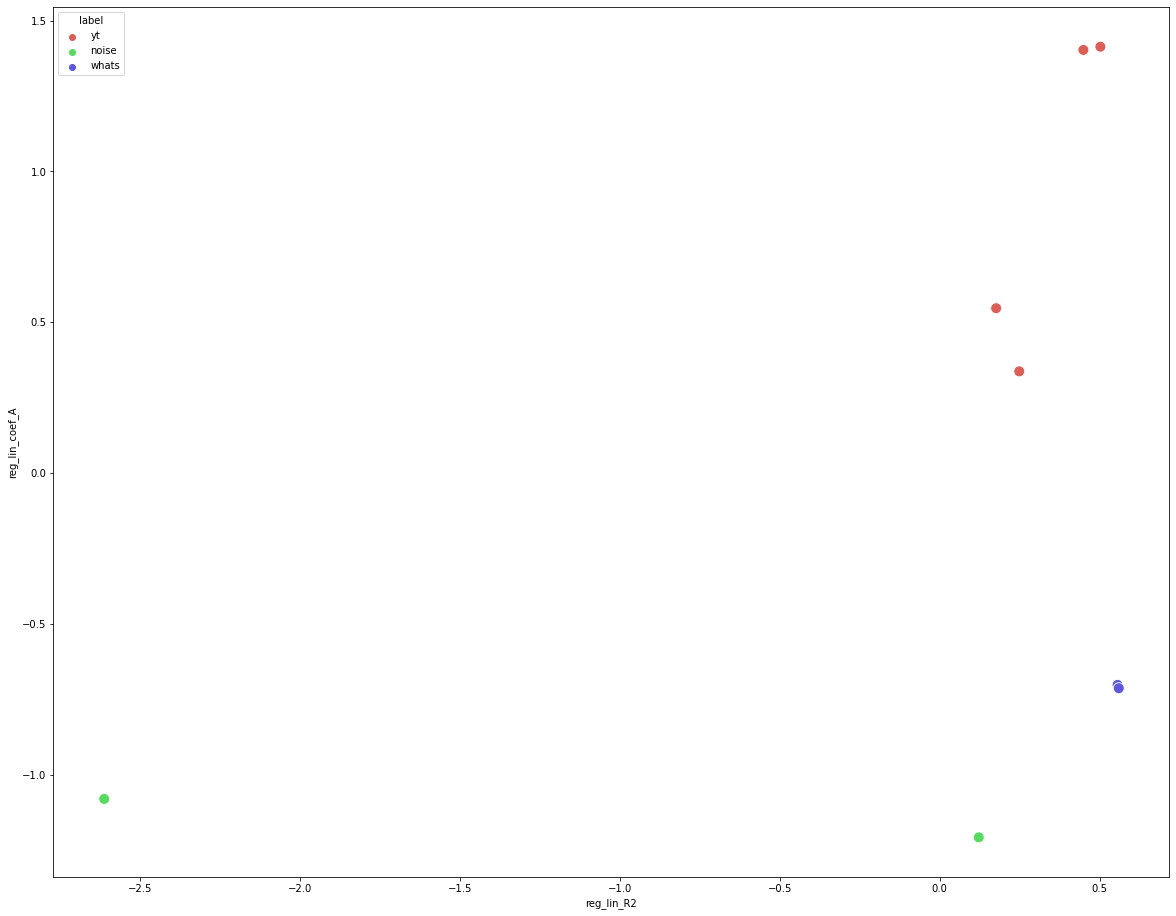

In [36]:
# Scaling
scaled_data = scale_data(new_data)

sns.scatterplot(x='reg_lin_R2' , y='reg_lin_coef_A', data=scaled_data, hue='label',s=120,palette='hls' )
plt.show()


In [37]:
#quite good, le coef de reg lin permet deja de deviner la classe
# whatsapp a aussi les meilleurs R2 de reg lin >0.9995
# La ou yt on est sur : 0.985 -> 0.998
# noise très faible coeff, et R2 faible

In [38]:
apply_classifier(scaled_data ,model = "KNN", test = False)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Accuracy for our training dataset with tuning is : 75.00%


In [39]:
apply_classifier(scaled_data ,model = "RF", test = False)

Fitting 2 folds for each of 168 candidates, totalling 336 fits
Accuracy for our training dataset with tuning is : 100.00%


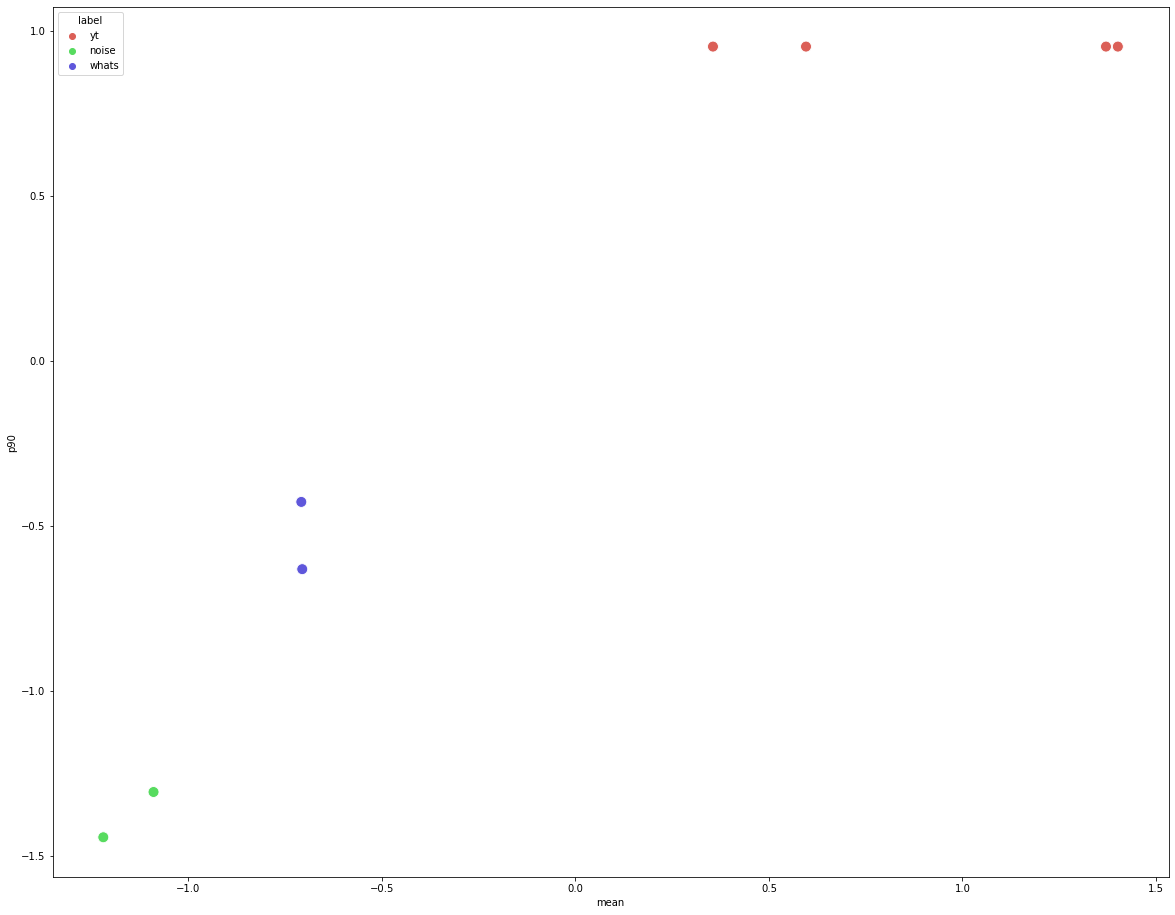

In [53]:
x_col = scaled_data.columns[randint(0,len(scaled_data.columns)-1)]
y_col = scaled_data.columns[randint(0,len(scaled_data.columns)-1)]
sns.scatterplot(x=x_col , y=y_col, data=scaled_data, hue='label',s=120,palette='hls' )
plt.show()